In [2]:
import av
import numpy as np
from PIL import Image
import os
import time

class VideoEncoder:
    def __init__(self, block_size=16, search_radius=8):
        self.block_size = block_size
        self.search_radius = search_radius
    
    def extract_frames(self, video_path, output_dir):
        """Извлекает кадры из видео и сохраняет их как JPEG."""
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        container = av.open(video_path)
        stream = container.streams.video[0]
        
        frames = []
        for frame in container.decode(stream):
            # Преобразование в массив numpy в формате grayscale
            img_array = frame.to_ndarray(format='gray')
            frames.append(img_array)
            
        return frames
    
    def sat_metric(self, block1, block2):
        """Вычисляет метрику SAT между двумя блоками."""
        return np.sum(np.abs(block1 - block2))
    
    def logarithmic_search(self, curr_block, ref_frame, x, y):
        """Реализует логарифмический поиск для оценки движения."""
        step_size = self.search_radius
        min_x, min_y = x, y
        min_cost = float('inf')
        
        while step_size >= 1:
            for dx in [-step_size, 0, step_size]:
                for dy in [-step_size, 0, step_size]:
                    new_x = min_x + dx
                    new_y = min_y + dy
                    
                    # Проверка границ
                    if (new_x < 0 or new_x + self.block_size > ref_frame.shape[1] or
                        new_y < 0 or new_y + self.block_size > ref_frame.shape[0]):
                        continue
                    
                    ref_block = ref_frame[new_y:new_y+self.block_size, 
                                        new_x:new_x+self.block_size]
                    cost = self.sat_metric(curr_block, ref_block)
                    
                    if cost < min_cost:
                        min_cost = cost
                        min_x, min_y = new_x, new_y
            
            step_size //= 2
            
        return min_x - x, min_y - y
    
    def motion_estimation(self, current_frame, reference_frame):
        """Оценка движения для всего кадра."""
        height, width = current_frame.shape
        motion_vectors = np.zeros((height // self.block_size, 
                                 width // self.block_size, 2))
        
        for i in range(0, height - self.block_size + 1, self.block_size):
            for j in range(0, width - self.block_size + 1, self.block_size):
                curr_block = current_frame[i:i+self.block_size, 
                                        j:j+self.block_size]
                
                dx, dy = self.logarithmic_search(curr_block, reference_frame, j, i)
                
                motion_vectors[i//self.block_size, 
                            j//self.block_size] = [dx, dy]
                
        return motion_vectors
    
    def motion_compensation(self, reference_frame, motion_vectors):
        """Компенсация движения для восстановления кадра."""
        height, width = reference_frame.shape
        compensated = np.zeros_like(reference_frame)
        
        for i in range(motion_vectors.shape[0]):
            for j in range(motion_vectors.shape[1]):
                dx, dy = motion_vectors[i, j]
                
                ref_y = i * self.block_size
                ref_x = j * self.block_size
                
                src_y = int(ref_y + dy)
                src_x = int(ref_x + dx)
                
                # Проверка границ
                if (src_x >= 0 and src_x + self.block_size <= width and
                    src_y >= 0 and src_y + self.block_size <= height):
                    compensated[ref_y:ref_y+self.block_size, 
                              ref_x:ref_x+self.block_size] = \
                        reference_frame[src_y:src_y+self.block_size, 
                                     src_x:src_x+self.block_size]
                
        return compensated
    
    def encode_video(self, input_path, output_dir):
        """Основной метод кодирования видео."""
        frames = self.extract_frames(input_path, output_dir)
        
        for i in range(1, len(frames)):
            # Оценка движения
            motion_vectors = self.motion_estimation(frames[i], frames[i-1])
            
            # Компенсация движения
            compensated_frame = self.motion_compensation(frames[i-1], motion_vectors)
            
            # Разница между текущим и компенсированным кадром
            residual = frames[i] - compensated_frame
            
            # Сохранение кадра
            self.save_frame(frames[i], os.path.join(output_dir, f'frame_{i}.jpg'))
            
            # Вывод прогресса
            print(f"Обработан кадр {i} из {len(frames)-1}")
            
        return True
    
    def save_frame(self, frame, filepath):
        """Сохраняет кадр как JPEG файл."""
        # Нормализация значений для сохранения в формате JPEG
        normalized = np.clip(frame, 0, 255).astype(np.uint8)
        image = Image.fromarray(normalized)
        image.save(filepath)

def main():
    # Пути к файлам
    input_video = "lr1_1.avi"
    output_dir = "encoded_frames"
    
    # Создание выходной директории, если её нет
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Инициализация кодера с параметрами из задания
    encoder = VideoEncoder(block_size=16, search_radius=8)
    
    print("Начало кодирования видео...")
    start_time = time.time()
    
    try:
        # Запуск процесса кодирования
        encoder.encode_video(input_video, output_dir)
        
        # Вывод статистики
        end_time = time.time()
        processing_time = end_time - start_time
        
        print(f"Кодирование завершено успешно!")
        print(f"Время обработки: {processing_time:.2f} секунд")
        print(f"Закодированные кадры сохранены в директории: {output_dir}")
        
    except Exception as e:
        print(f"Ошибка при кодировании: {str(e)}")

if __name__ == "__main__":
    main()

Начало кодирования видео...
Обработан кадр 1 из 67
Обработан кадр 2 из 67
Обработан кадр 3 из 67
Обработан кадр 4 из 67
Обработан кадр 5 из 67
Обработан кадр 6 из 67
Обработан кадр 7 из 67
Обработан кадр 8 из 67
Обработан кадр 9 из 67
Обработан кадр 10 из 67
Обработан кадр 11 из 67
Обработан кадр 12 из 67
Обработан кадр 13 из 67
Обработан кадр 14 из 67
Обработан кадр 15 из 67
Обработан кадр 16 из 67
Обработан кадр 17 из 67
Обработан кадр 18 из 67
Обработан кадр 19 из 67
Обработан кадр 20 из 67
Обработан кадр 21 из 67
Обработан кадр 22 из 67
Обработан кадр 23 из 67
Обработан кадр 24 из 67
Обработан кадр 25 из 67
Обработан кадр 26 из 67
Обработан кадр 27 из 67
Обработан кадр 28 из 67
Обработан кадр 29 из 67
Обработан кадр 30 из 67
Обработан кадр 31 из 67
Обработан кадр 32 из 67
Обработан кадр 33 из 67
Обработан кадр 34 из 67
Обработан кадр 35 из 67
Обработан кадр 36 из 67
Обработан кадр 37 из 67
Обработан кадр 38 из 67
Обработан кадр 39 из 67
Обработан кадр 40 из 67
Обработан кадр 41 из 

51.74983530758903
50.499555586153086
46.54803143041243
41.42368747974007
39.73749549819072


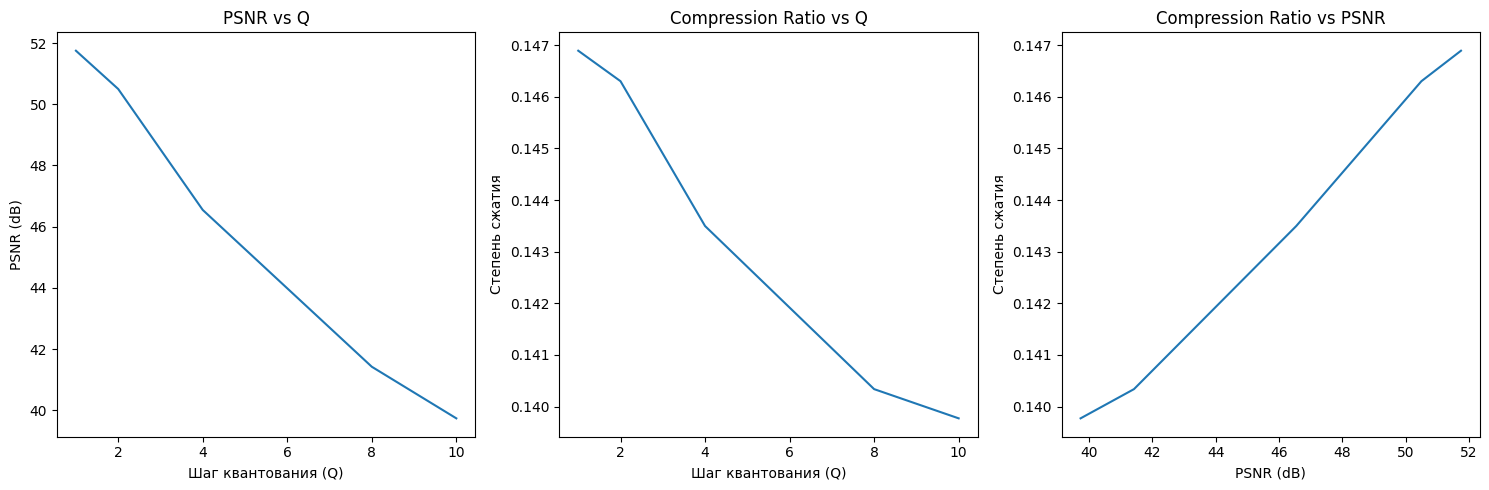

In [2]:
import av
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from scipy.fftpack import dct, idct
import math
import os
from collections import Counter

def dct2d(block: np.ndarray) -> np.ndarray:
    """
    Двумерное ДКП
    """
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2d(block: np.ndarray) -> np.ndarray:
    """
    Обратное двумерное ДКП
    """
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# def quantize(block: np.ndarray, q_step: int) -> np.ndarray:
#     """
#     Квантование ДКП коэффициентов
#     """
#     return np.round(block / q_step) * q_step

def quantize(block: np.ndarray, q_step: int) -> np.ndarray:
    """
    Квантование ДКП коэффициентов с использованием шага квантования q_step
    """
    size_block = block.shape[0]  # Определяем размер блока автоматически
    res = np.zeros((size_block, size_block))  # Создаём пустую матрицу для результата
    for i in range(size_block):
        for j in range(size_block):
            res[i][j] = round(block[i][j] / q_step) * q_step  # Выполняем квантование
    return res


def process_block(block: np.ndarray, q_step: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Обработка блока: ДКП -> Квантование -> Обратное ДКП
    """
    # Прямое ДКП
    dct_block = dct2d(block.astype(np.float64))
    
    # Квантование
    quantized_block = quantize(dct_block, q_step)
    
    # Обратное ДКП
    reconstructed_block = idct2d(quantized_block)
    
    return quantized_block, reconstructed_block

def logarithmic_search(curr_block: np.ndarray, 
                    reference_frame: np.ndarray, 
                    x: int, 
                    y: int, 
                    search_radius: int = 8) -> Tuple[int, int]:
    """
    Реализация алгоритма логарифмического поиска для оценки движения
    """
    block_size = curr_block.shape[0]
    best_x, best_y = x, y
    best_sad = float('inf')
    step = search_radius // 2

    while step >= 1:
        for dx in [-step, 0, step]:
            for dy in [-step, 0, step]:
                new_x = x + dx
                new_y = y + dy
                
                if (new_x < 0 or new_x + block_size > reference_frame.shape[0] or
                    new_y < 0 or new_y + block_size > reference_frame.shape[1]):
                    continue
                
                reference_block = reference_frame[new_x:new_x+block_size, 
                                            new_y:new_y+block_size]
                
                sad = np.sum(np.abs(curr_block - reference_block))
                
                if sad < best_sad:
                    best_sad = sad
                    best_x = new_x
                    best_y = new_y
        
        step //= 2
    
    return best_x - x, best_y - y

def calculate_entropy(data: np.ndarray) -> float:
    """
    Вычисление энтропии для массива данных
    """
    # Подсчет частот значений
    counter = Counter(data.flatten())
    total = len(data.flatten())
    
    # Вычисление энтропии
    entropy = 0
    for count in counter.values():
        probability = count / total
        entropy -= probability * math.log2(probability)
    return entropy

def calculate_bits_for_frame(dct_coeffs: np.ndarray, motion_vectors: np.ndarray) -> Tuple[float, float]:
    """
    Вычисление количества бит для кодирования кадра по формуле из документации
    """
    # Расчет Bits1 (для разностного кадра)
    N_DC = np.sum(dct_coeffs != 0)  # Количество ненулевых DC коэффициентов
    BC_dDC = dct_coeffs[dct_coeffs != 0]  # Значения DC коэффициентов
    
    # Вычисление Run/Level пар
    runs = []
    levels = []
    for coeff in dct_coeffs.flatten():
        if coeff != 0:
            levels.append(coeff)
            runs.append(len(runs))
    
    # Расчет компонентов формулы Bits1
    entropy_BC_dDC = calculate_entropy(BC_dDC) if len(BC_dDC) > 0 else 0
    sum_BC_dDC = np.sum(np.abs(BC_dDC)) if len(BC_dDC) > 0 else 0
    entropy_run_level = calculate_entropy(np.array(runs)) if runs else 0
    sum_BC_level = np.sum(np.abs(levels)) if levels else 0
    
    Bits1 = (entropy_BC_dDC * N_DC + 
            sum_BC_dDC + 
            entropy_run_level * len(runs) + 
            sum_BC_level)
    
    # Расчет Bits2 (для векторов движения)
    N_MV = motion_vectors.shape[0] * motion_vectors.shape[1]  # Количество макроблоков
    entropy_MV = calculate_entropy(motion_vectors)
    
    Bits2 = entropy_MV * N_MV
    
    return Bits1, Bits2

def compute_motion_compensated_frame(current: np.ndarray, 
                                reference: np.ndarray,
                                block_size: int = 16,
                                search_radius: int = 8,
                                q_step: int = 1,
                                return_vectors: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Вычисление разностного кадра с компенсацией движения и его обработка.
    Возвращает также векторы движения, если return_vectors=True
    """
    height, width = current.shape
    motion_vectors = np.zeros((height // block_size, width // block_size, 2), dtype=np.int8)
    diff_frame = np.zeros_like(current, dtype=np.int16)
    predicted_frame = np.zeros_like(current, dtype=np.uint8)
    reconstructed_frame = np.zeros_like(current, dtype=np.uint8)
    
    for i in range(0, height - block_size + 1, block_size):
        for j in range(0, width - block_size + 1, block_size):
            curr_block = current[i:i+block_size, j:j+block_size]
            
            # Оценка движения
            dx, dy = logarithmic_search(curr_block, reference, i, j, search_radius)
            motion_vectors[i // block_size, j // block_size] = [dx, dy]
            
            # Компенсация движения
            reference_block = reference[i+dx:i+dx+block_size, j+dy:j+dy+block_size]
            predicted_frame[i:i+block_size, j:j+block_size] = reference_block
            
            # Вычисление разностного блока
            diff_block = curr_block.astype(np.int16) - reference_block.astype(np.int16)
            
            # ДКП, квантование и обратное ДКП
            _, reconstructed_diff = process_block(diff_block, q_step)
            
            # Сохранение разностного блока
            diff_frame[i:i+block_size, j:j+block_size] = diff_block
            
            # Восстановление блока
            reconstructed_block = np.clip(reference_block.astype(np.int16) + 
                                    reconstructed_diff, 0, 255).astype(np.uint8)
            reconstructed_frame[i:i+block_size, j:j+block_size] = reconstructed_block
    
    if return_vectors:
        return diff_frame, reconstructed_frame, predicted_frame, motion_vectors
    return diff_frame, reconstructed_frame, predicted_frame

def calculate_psnr(original: np.ndarray, compressed: np.ndarray) -> float:
    """
    Вычисление PSNR между оригинальным и сжатым изображением
    """
    mse = np.mean((original.astype(np.float64) - compressed.astype(np.float64)) ** 2)
    # print(mse)
    if mse == 0:
        # return float('inf')
        return 60.0
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

def plot_metrics(q_steps: List[int], 
                psnr_values: List[float], 
                compression_ratios: List[float]):
    """
    Построение графиков метрик
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.plot(q_steps, psnr_values)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR vs Q')
    
    plt.subplot(132)
    plt.plot(q_steps, compression_ratios)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs Q')
    
    plt.subplot(133)
    plt.plot(psnr_values, compression_ratios)
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs PSNR')
    
    plt.tight_layout()
    plt.show()


def process_video(input_path: str, output_diff_path: str, output_recon_path: str, 
                q_step: int = 1) -> Tuple[float, float]:
    """
    Обработка видео с сохранением разностных и восстановленных кадров
    """
    # Создаем выходные папки, если они еще не существуют
    os.makedirs(os.path.dirname(output_diff_path), exist_ok=True)
    os.makedirs(os.path.dirname(output_recon_path), exist_ok=True)
    
    container = av.open(input_path)
    diff_container = av.open(output_diff_path, mode='w')
    recon_container = av.open(output_recon_path, mode='w')
    
    # Настройка выходных потоков
    diff_stream = diff_container.add_stream('mpeg4', 
                                            rate=container.streams.video[0].codec_context.rate)
    recon_stream = recon_container.add_stream('mpeg4',
                                            rate=container.streams.video[0].codec_context.rate)
    
    for stream in [diff_stream, recon_stream]:
        stream.width = container.streams.video[0].width
        stream.height = container.streams.video[0].height
        stream.pix_fmt = 'yuv420p'
    
    original_frames = []  # Сохраняем оригинальные кадры
    reconstructed_frames = []  # Сохраняем восстановленные кадры
    previous_frame = None
    total_bits_original = 0
    total_bits_compressed = 0
    frame_count = 0
    
    for frame in container.decode(video=0):
        frame_count += 1
        # Извлечение компоненты Y
        img = frame.to_ndarray(format='yuv420p')
        y_component = img[:diff_stream.height, :diff_stream.width].astype(np.uint8)
        
        # Сохраняем оригинальный кадр
        original_frames.append(y_component.copy())
        
        # Расчет исходного размера
        W = diff_stream.width
        H = diff_stream.height
        total_bits_original += W * H * 8
        
        if previous_frame is None:
            # Первый кадр сохраняем без изменений
            diff_frame = np.zeros_like(y_component)
            reconstructed_frame = y_component.copy()
            motion_vectors = np.zeros((H // 16, W // 16, 2), dtype=np.int8)
            dct_coeffs = dct2d(diff_frame.astype(np.float64))
        else:
            # Для остальных кадров применяем компенсацию движения и ДКП
            diff_frame, reconstructed_frame, predicted_frame, motion_vectors = compute_motion_compensated_frame(
                y_component, previous_frame, q_step=q_step, return_vectors=True)
            dct_coeffs = dct2d(diff_frame.astype(np.float64))
        
        # Сохраняем восстановленный кадр
        reconstructed_frames.append(reconstructed_frame.copy())
        
        # Расчет битов для текущего кадра
        bits1, bits2 = calculate_bits_for_frame(dct_coeffs, motion_vectors)
        total_bits_compressed += bits1 + bits2
        
        # Сохранение разностного кадра
        diff_frame_vis = np.clip(diff_frame + 128, 0, 255).astype(np.uint8)
        diff_out_frame = av.VideoFrame.from_ndarray(diff_frame_vis, format='gray')
        packet = diff_stream.encode(diff_out_frame)
        diff_container.mux(packet)
        
        # Сохранение восстановленного кадра
        recon_out_frame = av.VideoFrame.from_ndarray(reconstructed_frame, format='gray')
        packet = recon_stream.encode(recon_out_frame)
        recon_container.mux(packet)
        
        previous_frame = reconstructed_frame
    
    # Очистка буферов энкодеров
    for stream, container in [(diff_stream, diff_container), 
                            (recon_stream, recon_container)]:
        for packet in stream.encode():
            container.mux(packet)
        container.close()
    
    container.close()
    
    # Вычисление степени сжатия по новой формуле
    compression_ratio = (frame_count * W * H * 8) / total_bits_compressed
    
    # Вычисление PSNR между оригинальными и восстановленными кадрами
    psnr_values = [calculate_psnr(original_frames[i], reconstructed_frames[i]) 
                for i in range(len(original_frames))][1:]
    avg_psnr = np.mean(psnr_values)
    print(avg_psnr)
    
    return avg_psnr, compression_ratio

def main():
    input_path = 'lr1_1.avi'
    q_steps = [1, 2, 4, 8, 16, 32]
    q_steps = [1, 2, 4, 8, 10]
    psnr_values = []
    compression_ratios = []
    
    # Создаем папки для diff и recon видео
    diff_folder = "output/diff"
    recon_folder = "output/recon"
    os.makedirs(diff_folder, exist_ok=True)
    os.makedirs(recon_folder, exist_ok=True)
    
    for q in q_steps:
        # Генерация путей для diff и recon файлов
        diff_path = os.path.join(diff_folder, f"diff_q{q}.avi")
        recon_path = os.path.join(recon_folder, f"recon_q{q}.avi")
        
        psnr, ratio = process_video(
            input_path, 
            diff_path,  # Файл с разностными кадрами
            recon_path,  # Файл с восстановленными кадрами
            q
        )
        psnr_values.append(psnr)
        compression_ratios.append(ratio)
    
    plot_metrics(q_steps, psnr_values, compression_ratios)

if __name__ == '__main__':
    main()
